# PDE Modelling Mimic of 190413 experiment

## Objectives 
* Microscope movie was performed on 190413 that simply observed growth of a constitutively fluorescent strain on agar pads, varying in pad size and cell occupation
* Simulate each of the experimental setups executed
* eventually build into a fitting routine

## Model considerations 
* Species
    1. Cell density (sender and pulse cells)
    1. Nutrient density 
    1. mScarlet
* Reactions 
    1. cell growth and diffusion 
        * Cells diffuse very slowly
        * nutrient-dependent growth (from Liu et al 2011, Science) 
        $$  $$ 
    1. Constitutive fluorescence
        * Basal protein expression 
        * initial protein concentration set to fixed point of max nutrient
    1. Dilution and degradation 
        * Assume that all proteins are degradation tagged
    1. Diffusion 
        * Here, you're going to use convoultion of the diffusion kernel
        * Diffusion in/out of cell is considered faster than spatial diffusion at these scales
    1. Parameters
        * We are also assuming, for the moment, that each time point is 6 minutes. Parameters with time dimensions shown below may use different units than the parameter from the cited paper.
        * dx: Length modification of diffusion terms. In the compartmental model, diffusion is calculated via Ficks' first law, where the flux between two adjacent compartments is equal to the flux multiplied by the area of the interface between the components :  
        $\frac{\mathrm{d} C}{\mathrm{d} t} $ 
        in continuous form gives up 
        $\Delta C = D \frac{A}{V} \frac{\Delta C}{\Delta x} = D \frac{2.25 \cdot 5 \cdot \mathrm{scale}^2 \mathrm{mm}^2}{\mathrm{scale} \cdot 2.25^2 \cdot 5 \mathrm{mm}^3} \frac{\Delta C \cdot \mathrm{scale}}{2.25 \mathrm{mm}} = \frac{D \Delta C \mathrm{scale}^2}{2.25^2 \mathrm{mm}^2}$. the dx parameter below is the symbol $A$ in this equation.
        * Dc : Diffusion rate for cells. $7\frac{mm^2}{min}$
        * rc : Division rate of cells. $\frac{1.14}{min}$
        * Kn : Half-point of nutrient availability. 75
        * Dn : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * kn : Consumption rate of nutrient by cells
        * Da : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * xs : Expression rate of protein. 


In [1]:
# imports
# from __future__ import division, print_function

import itertools as itt

import numpy as np
import pandas as pd
import os
import sys
import string
import selenium
import scipy.integrate as itg
import scipy.sparse as sparse

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # Add the path of ffmpeg here!!

import matplotlib.animation as anm
import skimage.io
import skimage.transform
import numba
# import gc
import emcee
import corner

from multiprocessing import Pool, Process, cpu_count

%load_ext memory_profiler
%load_ext line_profiler
import timeit

# from IPython.display import HTML

from omnisim import PrepPad, Fitter, Jacobian, Simulator

# rc = {'lines.linewidth': 2, 
#       'axes.labelsize': 18, 
#       'axes.titlesize': 24, 
#       'xtick.labelsize': 18, 
#       'ytick.labelsize': 18, 
#       'legend.fontsize': 18,
#       'axes.facecolor': 'DFDFE5'}

# sns.set_context('paper', rc=rc)

%matplotlib inline

## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

This is achieved though a bunch of subtractions between offset arrays.

Attempt fitting w/o crowding

# Helper functions used to define the arenas 
### Needs
* read excel or csv files 
* rescaling arrays and contents 
* convert row/col to array index


* disk function, projects circular areas onto an input grid 
* 

## Try rewriting into class-based approach to simulation to speed up fitting

In [2]:
def logprior(p0):
    from scipy.stats import cauchy, norm

    if np.any(p0<0):
        return -np.inf
    Dn, rc, Kn, Hn, pn = p0
    if np.any(np.array([Dn,rc,Kn,Hn,pn])==0):
        return -np.inf

    # Boundaries are applied by imposing Gaussian edges to parameters that fall outside a reasonable range
    val = 0

    # Dn is jeffrey's
    val += (-1/2)*np.log(Dn) + norm.logpdf(1e3*np.max([0, Dn-1e-3, 1e3*(1e-6-Dn)]),0,0.1)

    # rc under cauchy distribution
    cauchy_params = (0.00022759430504618882, 1.8699032413798176e-05)
    val += cauchy.logpdf(rc, *cauchy_params)

    # Kn uniform between 0 and 100 (maybe change this for appearance's sake)
    if Kn>200 or Kn<1:
        val += norm.logpdf(np.max([0,Kn-200, 10*(1-Kn)]),0,0.01)

    # Hn uniform between 0.8 and 20
    if Hn > 20 or Hn < 0.5:
        val += norm.logpdf(np.max([0,10*(Hn-20), 10*(0.5-Hn)]),0,0.01)

    # pn is jeffrey's
    val += (-1/2)*np.log(pn) + norm.logpdf(np.max([0,5e2*(1e-3-pn),pn-2]),0,1)

    # 100*rc/pn is the amount of cells that can be produced in a unitary arena
    # let's say it should be able to produce confluence, or 1 unit of cell density, with std of 0.2
    val += norm.logpdf(100*rc/pn, 1, 0.4)
    return val

# Get prior-distributed parameters
# nwalkers = 12
# ndim = 5
# if False:
#     nsteps = 10000
#     Dn_vals = np.power(10,np.linspace(-5.9,-2.9,nwalkers))
#     rc_vals = np.linspace(1.1e-4,2.9e-4,nwalkers)
#     Kn_vals = np.linspace(1,99,nwalkers)
#     Hn_vals = np.linspace(0.6, 19, nwalkers)
#     pn_vals = np.power(np.linspace(1.2e-4,3,nwalkers),2)
#     pos = np.array([np.random.choice(Dn_vals, nwalkers), 
#                     np.random.choice(rc_vals, nwalkers), 
#                     np.random.choice(Kn_vals, nwalkers), 
#                     np.random.choice(Hn_vals, nwalkers), 
#                     np.random.choice(pn_vals, nwalkers)]).T
# #     nwalkers, ndim = pos.shape
#     with Pool() as pool:
#         sampler = emcee.EnsembleSampler(nwalkers, ndim, logprior, pool=pool)
#         sampler.run_mcmc(pos, nsteps);
#     flatchain = np.reshape(sampler.get_chain()[3000:,:,:].copy(),(nwalkers*(nsteps-1000),ndim),order='F')
#     np.save('prior_flatchain.npy', flatchain)
# else:
#     flatchain = np.load('prior_flatchain.npy')
    
# corner.corner(flatchain[12*3000:,:]);

In [3]:
fitter = Fitter(6,[0],logprior_fun=logprior)

In [4]:
p0 = np.array([0, 5e-5, 2.2e-4, 80, 8, 0.008])
sim = fitter.sim_list[0]
print(sim.cell_init.shape)
%time sim.sim(p0)

(128, 128)
CPU times: user 44.8 s, sys: 19.3 s, total: 1min 4s
Wall time: 18.8 s


In [9]:
# Attempting the prior predictive test 
# in short, this is attempting to draw from the joint distribution of (y,theta) 
# where theta is drawn from the prior and y is drawn from the likelihood of y given theta. 
# Your first thought is that you have to draw and determine distribution via mcmc for y, sample y, repeat.
# In other words, a full round of MCMC for each draw of (y,theta), which is itself generated via mcmc.
# On the other hand, for very small residual sigma, the distribution of (y,theta) will be very close to the truth.
# Let's take a beat to estimate what that sigma should be: look at higher scales of experiments and 
scale_list = np.power(2,np.array([6,7,8]))
pad_list = [0,2,4,5,6,7,8]
def sim_pad(args):
    scale, pad_ind = args
    pad = PrepPad(scale, pad_ind)
    sim = Simulator(pad)

inputs = list(itt.product(scale_list, pad_list))
print(inputs)
with Pool() as pool:
    pool.map(sim_pad, inputs[:2])


[(64, 0), (64, 2), (64, 4), (64, 5), (64, 6), (64, 7), (64, 8), (128, 0), (128, 2), (128, 4), (128, 5), (128, 6), (128, 7), (128, 8), (256, 0), (256, 2), (256, 4), (256, 5), (256, 6), (256, 7), (256, 8)]


In [4]:

# Setup MCMC from prior-distributed parameters
datecode = '190908'
save_tmpl = 'worker_outputs/pool_outputs/low_sensitivity_all_pads_run_emcee_{}.csv'
nsteps = 20
run_flag = True

scale_exp = 3
# for pad_ind in [0,2,4,5,6,7,8]:
pad_list = [0,2,4,5,6,7,8]
save_file = save_tmpl.format(datecode)
fitter = Fitter(scale_exp, pad_list, logprior,4)
post_pos = flatchain[np.random.choice(np.arange(flatchain.shape[0]),nwalkers),:]

# nsteps = 10000
# with Pool() as pool:
#     post_sampler = emcee.EnsembleSampler(nwalkers, ndim, fitter.resfun, pool=pool)
#     print('starting')
#     post_sampler.run_mcmc(post_pos, nsteps, progress=True);
#     post_flatchain = post_sampler.get_chain(flat=True)
#     pd.DataFrame(post_flatchain).to_csv(save_file, header=False, mode='w')

In [17]:
post_flatchain = pd.read_csv('worker_outputs/pool_outputs/low_sensitivity_run_emcee_190908_pad_0.csv').values

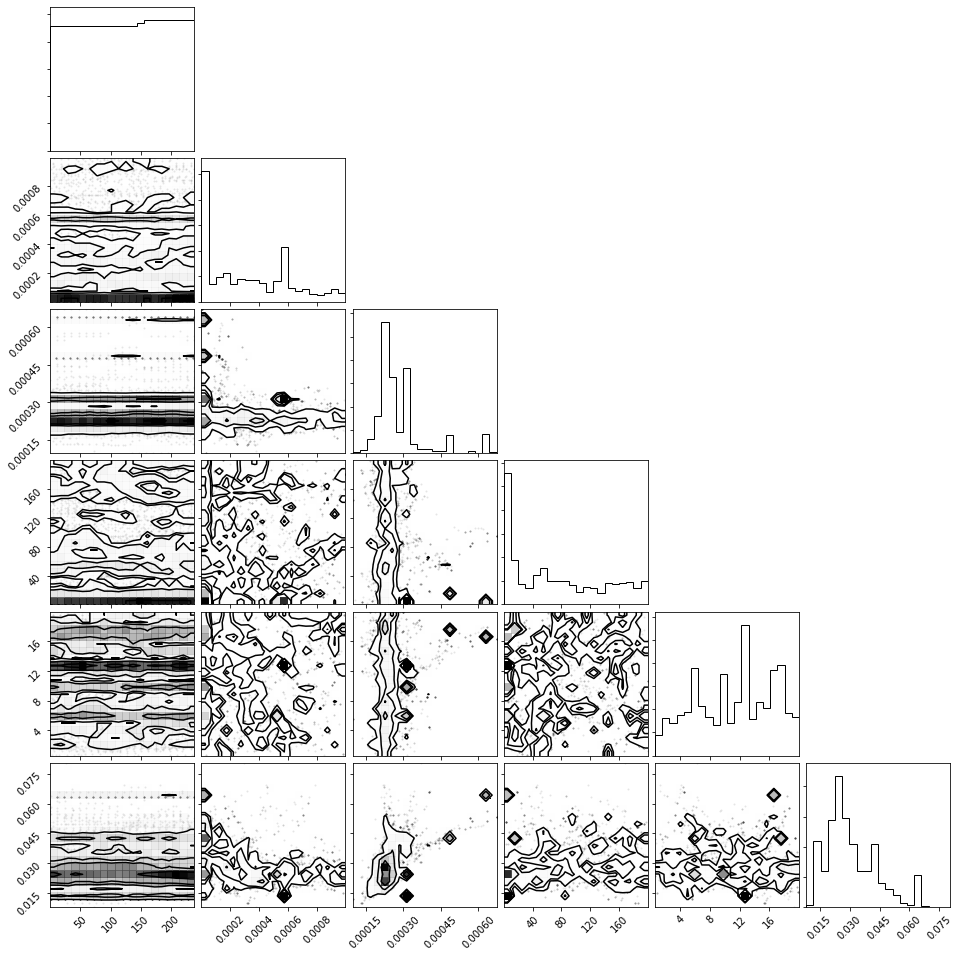

In [18]:
corner.corner(post_flatchain[4000:,:]);

In [ ]:
scale_list = np.power(2,np.array([3]))
pad_inds = [0,2,7,8]
star_args = itt.product(scale_list,pad_inds)
with Pool() as pool:
    pad_list = pool.starmap(PrepPad, star_args)
sim_list = list(map(Simulator, pad_list))



In [ ]:

p0 = np.array([0, 5e-5, 2.2e-4, 80, 8, 0.008])
for sim in sim_list:
    print(sim.scale)
    %time sim.sim(p0)
    print(sim.sim_arr.shape)

In [ ]:
bins = np.linspace(-1.5,1.5,21)
for sim in sim_list:
    _, _, n_h, n_w = sim.sim_arr.shape
    for slicefun, pov_ind, exp_arr in zip(sim.slice_functions, sim.pov_inds, sim.exp_list):
        _, s_h, s_w = exp_arr.shape
        yslice, xslice = slicefun(n_h, n_w, s_h, s_w, sim.scale)
        exp_im = exp_arr[-1,:,:]
        sim_im = sim.sim_arr[-1,0,yslice,xslice]
        plt.figure()
#         _ = plt.hist(exp_im,bins=bins,alpha=0.4)
#         _ = plt.hist(sim_im,bins=bins,alpha=0.4)
#         _ = plt.hist(sim_im-exp_im,bins=bins,alpha=0.4,color='r')
        _ = plt.imshow(sim_im-exp_im,vmin=-1,vmax=1)
        plt.title(pov_ind)


In [86]:
scale_list = np.power(2,np.array([3]))
pad_list = [0,2,4,5,6,7,8]
def sim_pad(args):
    scale, pad_ind = args
    pad = PrepPad(scale, pad_ind)
    sim = Simulator(pad)
    return sim

inputs = list(itt.product(scale_list, pad_list))
with Pool() as pool:
    sim_list = pool.map(sim_pad,inputs)


In [87]:
exp_arrs = [sim.exp_list[0] for sim in sim_list]

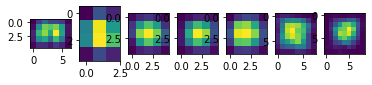

In [88]:
n_arrs = len(exp_arrs)
fig, axs = plt.subplots(1,n_arrs)
[ax.imshow(arr[20,:,:].astype(np.float)) for ax, arr in zip(axs, exp_arrs)]

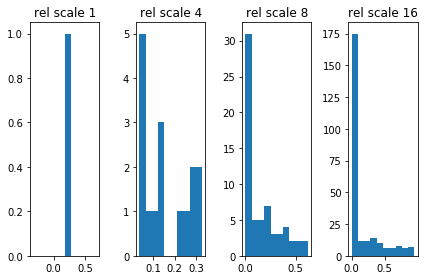

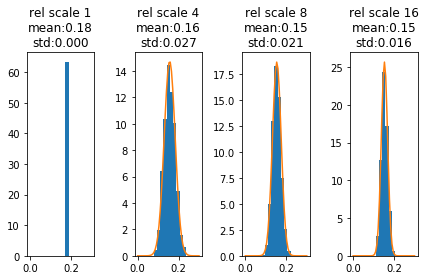

In [15]:
# Compare a single pixel to the histograms of
from scipy.stats import norm
rel_scale = scale_list // (2**4)
rs_dict = dict(zip(rel_scale, exp_arrs))

def resample_means(vec):
    return np.mean(np.random.choice(vec, len(vec)))

def arr_mean_resample(sub_arr, n_reps=1000):
    vec = sub_arr.flatten().astype(np.float)
    means = np.array(list(map(resample_means, [vec.copy() for i in range(n_reps)])))
    return means

def pixel_resample(arr, rs, t, i, j):
    return arr_mean_resample(arr[t,i*rs:(i+1)*rs,j*rs:(j+1)*rs])

def pixel_std(arr, rs, t, i, j):
    means = pixel_resample(arr,rs,t,i,j)
    fit = norm.fit(means)
    return fit[1]

def pixel_std_wrapper(rs, t, i, j):
    arr = rs_dict[rs]
    return (pixel_std(arr, rs, t, i, j), rs, t, i, j)
    
i, j = 5, 3
fig, axs = plt.subplots(1,n_arrs)
_ = [ax.hist(arr[20,i*rs:(i+1)*rs,j*rs:(j+1)*rs].astype(np.float).flatten()) for rs, ax, arr in zip(rel_scale, axs, exp_arrs)]
_ = [ax.set_title('rel scale {}'.format(xx)) for ax, xx in zip(axs, rel_scale)]
fig.tight_layout()

resamples = [pixel_resample(arr,rs,20,i,j) for rs, ax, arr in zip(rel_scale, axs, exp_arrs)]
fits = [norm.fit(xx) for xx in resamples]

x_vec = np.linspace(0,0.3,50)
bins = np.linspace(0,0.3,20)

fig, axs = plt.subplots(1,n_arrs)
_ = [ax.hist(resample,density=True,bins=bins) for ax, resample in zip(axs, resamples)]
_ = [ax.plot(x_vec, norm.pdf(x_vec, *fit)) for ax, fit in zip(axs, fits)]
_ = [ax.set_title('rel scale {}\nmean:{:0.2f}\nstd:{:0.3f}'.format(xx, *fit)) for ax, xx, fit in zip(axs, rel_scale, fits)]
fig.tight_layout()


In [10]:

n_f, h, w = exp_arrs[0].shape
pix_vecs = list(itt.product(np.arange(n_f), np.arange(h), np.arange(w)))

# all_pix_stds = [pixel_std_wrapper(rs, t, i, j) for rs in rel_scale[1:] for t,i,j in pix_vecs]

In [16]:
inputs = [(rs, t, i, j) for rs in rel_scale[1:] for t,i,j in pix_vecs]
with Pool() as pool:
    all_pix_stds = pool.starmap(pixel_std_wrapper,inputs)
columns = ('std', 'rs', 't','i','j')
df = pd.DataFrame(data=all_pix_stds, columns=columns)


In [81]:
pix_stds_one = [pixel_std_wrapper(rs, t, i, j) for rs in rel_scale[:1] for t,i,j in pix_vecs]
columns = ('std', 'rs', 't','i','j')
df_one = pd.DataFrame(data=pix_stds_one, columns=columns)


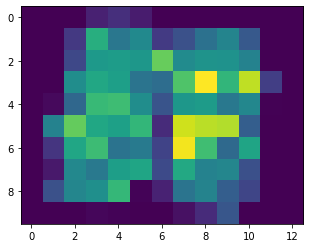

In [63]:
gb_rs_frame = df.groupby(['rs','t'])
arr = gb_rs_frame.get_group((4,10)).pivot(index='i',columns='j',values='std').values
plt.imshow(arr)

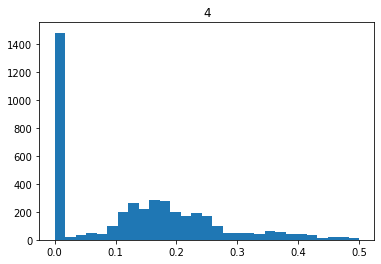

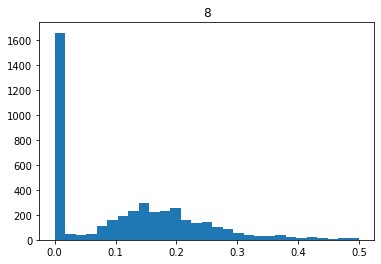

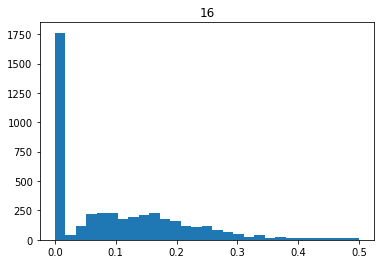

In [23]:
gb_rs = df.groupby('rs')
for sub_inds in gb_rs:
    plt.figure()
    sub_df = sub_inds[1]
    _ = plt.hist(sub_df['std']/exp_arrs[0].flatten(),bins=np.linspace(0,0.5,30))
    plt.title(sub_df['rs'].values[0])

/home/jmp/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jmp/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


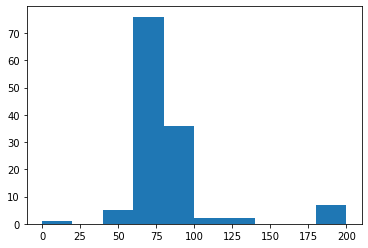

In [12]:
_ = plt.hist(nut_arr[34,:,:].flatten())

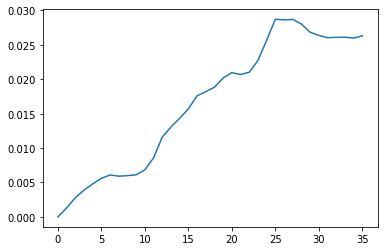

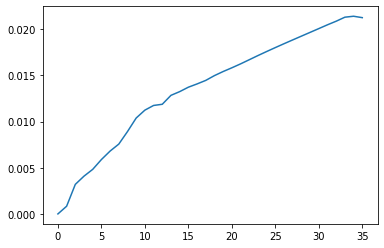

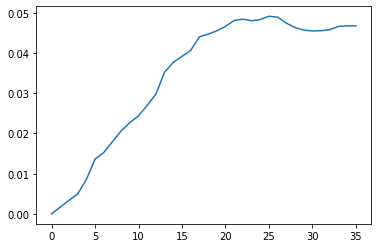

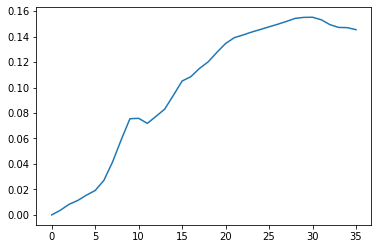

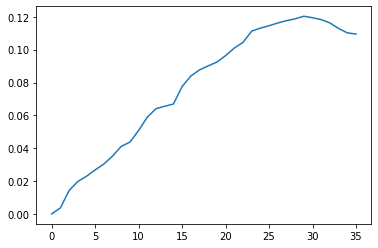

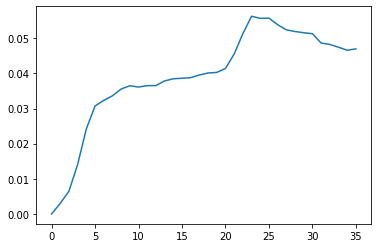

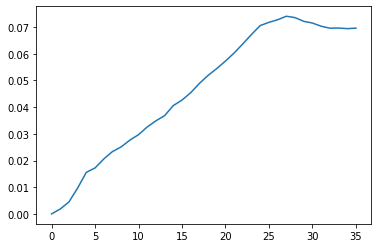

In [6]:
# sim_list = [Simulator(PrepPad(2**4,pad_ind)) for pad_ind in [0,2,4,5,6,7,8]]
p0 = np.array([0, 5e-5, 3.2e-4, 80, 8, 0.008])
Dc, Dn, rc, Kn, Hn, pn = p0
# _ = [sim.sim(p0) for sim in sim_list]
for pad_ind, sim in zip(pad_list, sim_list):
    plt.figure()
    sim_nut = sim.sim_arr[:,1,:,:]
    
    n_frames, h, w = sim_nut.shape
    # footprint = np.array([[[1]],[[1]],[[1]]])
    x_vec, y_vec = np.array(list(itt.product(np.arange(h)-h/2, np.arange(w)-w/2))).T
    phi_vec, r_vec = conv_cart_to_polar(x_vec, y_vec)
    nut_vec = sim_nut.flatten()
    r_vec = np.tile(r_vec, n_frames)
    phi_vec = np.tile(phi_vec, n_frames)
    frame_vec = np.repeat(select_frames[:-1],h*w)
    
    t_vec = pad_times_df.groupby('pad').get_group(pad_list[ind])['time'].values[select_frames[:-1]]
    t_vec = np.repeat(t_vec, h*w)

    columns = ('radius','time','nutrient','frame','phi')
    
    plt.plot((sim_nut_vec[0]-sim_nut_vec)*rc/pn - (sim_cell_vec-sim_cell_vec[0]))

In [131]:
from IPython.display import HTML
from omnisim import hill
import matplotlib.animation as anm

def write_stitched_mp4(im_arr):
    t, h, w = im_arr.shape
    # Set up figure    
    fig, axs = plt.subplots(1, 1, figsize=(8,8))
    im = axs.imshow(np.zeros((h,w)),interpolation='none',animated=True,vmax=150,vmin=0)
    [ax.set_xticks([]) for ax in [axs]]
    [ax.set_yticks([]) for ax in [axs]]
    plt.close('all')
    
    def animate(ind):
        im.set_array(im_arr[ind,:,:])
            
    anim = anm.FuncAnimation(fig, animate,frames=t)
    return anim



pad_times_df = pd.read_csv('pad_times.csv',index_col=0)
select_frames = np.arange(15,41)
ind = 5
exp_arr = exp_arrs[ind][10:,:,:]
t_vec = pad_times_df.groupby('pad').get_group(pad_list[ind])['time'].values[select_frames]
t_vec.shape = (len(select_frames),1,1)
t, h, w =exp_arr.shape
diff_arr = np.diff(exp_arr,axis=0)/exp_arr[:-1,:,:]/np.tile(np.diff(t_vec,axis=0),(1,h,w))

p0 = np.array([0, 5e-5, 3.2e-4, 30, 2, 0.008])
Dc, Dn, rc, Kn, Hn, pn = p0
nut_vals = np.linspace(0.001,200)
nut_avail = hill(nut_vals, Hn, Kn)

nut_arr = np.interp(diff_arr/rc, nut_avail, nut_vals)

anim = write_stitched_mp4(nut_arr)
HTML(anim.to_html5_video())


In [132]:

def conv_cart_to_polar(x_vec, y_vec):
    # Convert vectors to polar coords
    phi_vec = np.ones(x_vec.shape,dtype=np.float)*np.pi/2
    quad_inds = (x_vec==0 )&(y_vec<0)
    if np.any(quad_inds):
        phi_vec[quad_inds] = 3*np.pi/2
    quad_inds = x_vec > 0
    if np.any(quad_inds):
        phi_vec[quad_inds] = np.arctan(y_vec[quad_inds]/x_vec[quad_inds])
    quad_inds = x_vec < 0
    if np.any(quad_inds):
        phi_vec[quad_inds] = np.pi + np.arctan(y_vec[quad_inds]/x_vec[quad_inds])
    phi_vec[phi_vec<0] = phi_vec[phi_vec<0]+2*np.pi
    r_vec = np.sqrt(np.power(y_vec,2) + np.power(x_vec,2))
    return phi_vec, r_vec



pad_times_df = pd.read_csv('pad_times.csv',index_col=0)
select_frames = np.arange(5,41)
ind = 5
for ind in pad_list:
    exp_arr = exp_arrs[ind]
    t_vec = pad_times_df.groupby('pad').get_group(pad_list[ind])['time'].values[select_frames]
    t_vec.shape = (len(select_frames),1,1)
    t, h, w =exp_arr.shape
    diff_arr = np.diff(exp_arr,axis=0)/exp_arr[:-1,:,:]/np.tile(np.diff(t_vec,axis=0),(1,h,w))
    
    p0 = np.array([0, 5e-5, 3.2e-4, 30, 2, 0.008])
    Dc, Dn, rc, Kn, Hn, pn = p0
    nut_vals = np.linspace(0.001,200)
    nut_avail = hill(nut_vals, Hn, Kn)
    
    nut_arr = np.interp(diff_arr/rc, nut_avail, nut_vals)

    anim = write_stitched_mp4(nut_arr)
    HTML(anim.to_html5_video())

    n_frames, h, w = nut_arr.shape
    # footprint = np.array([[[1]],[[1]],[[1]]])
    x_vec, y_vec = np.array(list(itt.product(np.arange(h)-h/2, np.arange(w)-w/2))).T
    phi_vec, r_vec = conv_cart_to_polar(x_vec, y_vec)
    nut_vec = nut_arr.flatten()
    r_vec = np.tile(r_vec, n_frames)
    phi_vec = np.tile(phi_vec, n_frames)
    t_vec = pad_times_df.groupby('pad').get_group(pad_list[ind])['time'].values[select_frames[:-1]]
    t_vec = np.repeat(t_vec, h*w)
    frame_vec = np.repeat(select_frames[:-1],h*w)
    columns = ('radius','time','nutrient','frame','phi')
    sub_df = pd.DataFrame(dict(zip(columns,[r_vec, t_vec, nut_vec,frame_vec,phi_vec])))
# [len(xx) for xx in [r_vec, t_vec, nut_vec,frame_vec]]

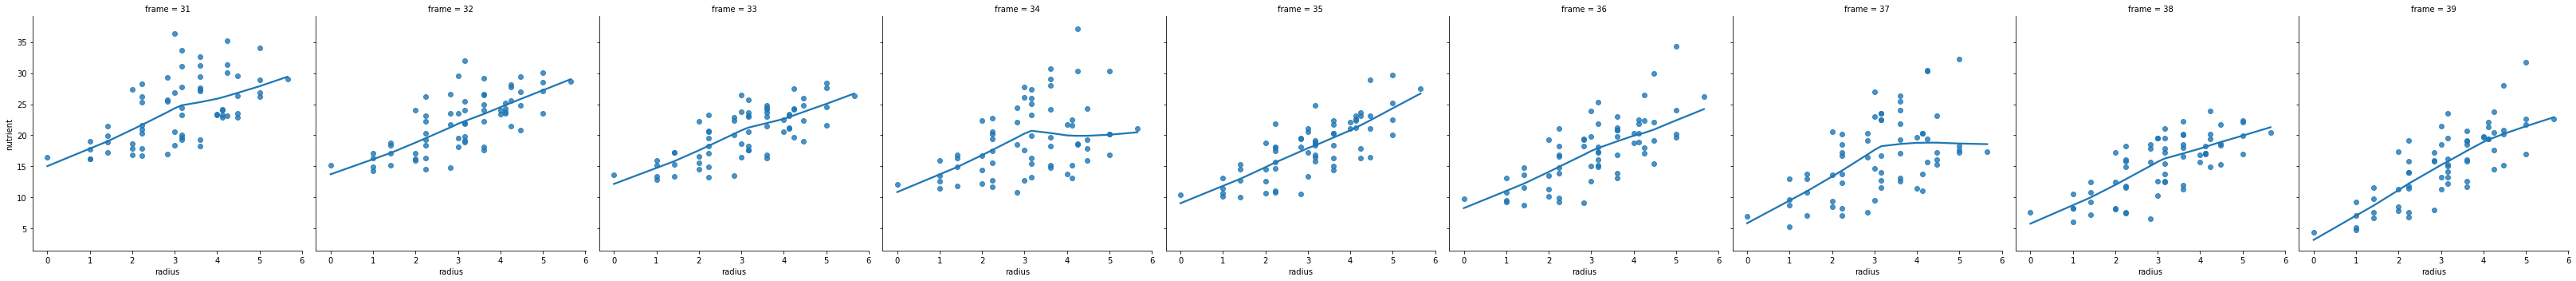

In [138]:
plot_df = pd.DataFrame(dict(zip(columns,[r_vec, t_vec, nut_vec,frame_vec,phi_vec])))
plot_df = plot_df.loc[plot_df.frame>30,:]
g = sns.lmplot(data=plot_df,x='radius',y='nutrient',col='frame',lowess=True)

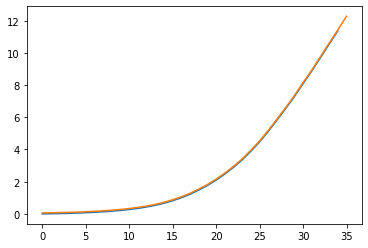

In [38]:
rc = 3e-4
pn = 1e-3
exp_arr = sim_list[1].exp_list[0]
exp_vec = np.sum(np.sum(exp_arr,axis=-1),axis=-1)
exp_vec_diff = np.diff(exp_vec)
t_vec = pad_times_df.groupby('pad').get_group(0)['time'].values[5:41]
nut_deriv_vec = exp_vec_diff/np.diff(t_vec)/rc*(-pn)
nut_est_vec = np.interp(exp_vec_diff/np.diff(t_vec)/exp_vec[:-1]/rc, nut_avail, nut_vals)
nut_depletion = np.array([np.sum((nut_deriv_vec*np.diff(t_vec))[:xx]) for xx in np.arange(0,len(t_vec)-1)])
plt.plot((-nut_depletion*rc/pn))
plt.plot(exp_vec)

In [20]:
[fitter.sim_list[0].make_exp_movie()[]]

In [26]:
def delta_c_helper(sim):
    exp_im = sim.make_exp_movie()
    return exp_im[-1,:,:].mean() - exp_im[0,:,:].mean()
print([delta_c_helper(sim) for sim in fitter.sim_list])

[0.03233191346421836, 0.013867031596284973, 0.015185095162855254, 0.009821010045707226, 0.005000580400228501, 0.03186598344795099, 0.0715010182915226]


In [22]:
print([sim])

0.03256738352926611

In [23]:
len(fitter.sim_list)

7

In [10]:
print(sim.__dict__.keys())

dict_keys(['cell_init', 'dims', 'initial_array', 't_eval', 'atol', 'rtol', 'dx', 'scale', 'pad', 'pov_inds', 'fn_list', 'slice_functions', 'jacobian', 'exp_list', 'p0', 'args', 'sim_arr', 'sim_tvc'])
